In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
from sklearn import preprocessing

In [59]:
# Leer el archivo CSV
archivo_csv = 'df_result_3_tomodel_noh_enaho.csv'
df = pd.read_csv(archivo_csv)
df.head()

,VACUNA,ANIO,MES,PROVINCIA,RANGO_EDAD,CANTIDAD DE PERSONAL,POBLACION,PRESUPUESTO,CANTIDAD,UBIGEO,ALFABETISMO,AGUA_POTABLE,DEMORA_CITA_horas,DEMORA_TRASLADO_horas
0,AMA,2019,ABRIL,CORONEL PORTILLO,1_ANIO,932,5690,998497,207,250100,0.233,0.527,1.254,0.251
1,AMA,2019,ABRIL,PADRE ABAD,1_ANIO,54,6037,998497,31,250300,0.056,0.667,0.500,0.375
2,AMA,2019,AGOSTO,CORONEL PORTILLO,1_ANIO,884,5690,3650033,75,250100,0.161,0.292,6.270,0.216
3,AMA,2019,AGOSTO,PADRE ABAD,1_ANIO,49,6037,3650033,13,250300,0.219,0.667,0.310,0.119
4,AMA,2019,DICIEMBRE,CORONEL PORTILLO,1_ANIO,887,5690,1953340,131,250100,0.186,0.537,38.927,0.230


In [60]:
# Add Mes-num
meses = ['ENERO', 'FEBRERO','MARZO','ABRIL','MAYO','JUNIO','JULIO', 'AGOSTO','SETIEMBRE','OCTUBRE','NOVIEMBRE', 'DICIEMBRE' ]
diccionario = {mes : i+1 for i, mes in enumerate(meses)}
df["MES_NUM"] = df["MES"].apply(lambda x: diccionario.get(x,None))

# Sorting
df.sort_values(by=['VACUNA','PROVINCIA','ANIO','MES_NUM'], inplace=True)

# Rename
df.rename(columns={"CANTIDAD DE PERSONAL": "CANTIDAD_DE_PERSONAL"}, inplace = True)

In [61]:
# Estandarizar las columnas
#scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()

cols_sc = ["CANTIDAD", "CANTIDAD_DE_PERSONAL" ,"PRESUPUESTO", "POBLACION"] 
scaler.fit(df.loc[:,cols_sc].to_numpy())
df.loc[:,cols_sc] = scaler.transform(df.loc[:,cols_sc].to_numpy())

df.head()

,VACUNA,ANIO,MES,PROVINCIA,RANGO_EDAD,CANTIDAD_DE_PERSONAL,POBLACION,PRESUPUESTO,CANTIDAD,UBIGEO,ALFABETISMO,AGUA_POTABLE,DEMORA_CITA_horas,DEMORA_TRASLADO_horas,MES_NUM
36,AMA,2020,ENERO,ATALAYA,1_ANIO,0.033146,0.0,0.194177,0.002098,250200,0.130,0.556,0.560,0.060,1
40,AMA,2020,FEBRERO,ATALAYA,1_ANIO,0.033442,0.0,0.189663,0.020280,250200,0.128,0.444,0.410,0.153,2
52,AMA,2020,MARZO,ATALAYA,1_ANIO,0.033738,0.0,0.186726,0.015385,250200,0.143,0.207,6.988,0.119,3
24,AMA,2020,ABRIL,ATALAYA,1_ANIO,0.035218,0.0,0.204631,0.002098,250200,0.314,0.750,0.000,0.000,4
56,AMA,2020,MAYO,ATALAYA,1_ANIO,0.034034,0.0,0.175326,0.024476,250200,0.552,0.000,0.000,0.000,5


In [62]:
df["ANIO"] = df["ANIO"].astype(str)

# Shifting
df_list=[]
for item,df_group in df.groupby(['PROVINCIA','VACUNA']):
  df_group.set_index(['VACUNA', 'ANIO', 'MES', 'PROVINCIA', 'RANGO_EDAD',
       'CANTIDAD_DE_PERSONAL', 'POBLACION', 'PRESUPUESTO',
       'UBIGEO', 'ALFABETISMO', 'AGUA_POTABLE', 'DEMORA_CITA_horas',
       'DEMORA_TRASLADO_horas', 'MES_NUM'], inplace = True)
  df_group_shifted = df_group.shift(2)
  df_group_shifted.reset_index(inplace=True)
  df_list.append(df_group_shifted)
df_shifted_total = pd.concat(df_list)

In [63]:
# Remove Purus
df = df_shifted_total[df_shifted_total['PROVINCIA'] != 'PURUS']

In [64]:
# Remove nan
df = df.dropna(subset=['CANTIDAD'])

In [65]:
# Supongamos que tienes tus datos en un DataFrame llamado df
# Dividir los datos en variables predictoras (X) y la variable objetivo (y)
X = df[['ANIO', 'MES', 'PROVINCIA', 'VACUNA', 'CANTIDAD_DE_PERSONAL', 'POBLACION', 'PRESUPUESTO', 'ALFABETISMO', 'AGUA_POTABLE', 'DEMORA_CITA_horas', 'DEMORA_TRASLADO_horas']]
#X = df[['ANIO', 'CANTIDAD_DE_PERSONAL', 'POBLACION', 'PRESUPUESTO', 'ALFABETISMO', 'AGUA_POTABLE', 'DEMORA_CITA_horas', 'DEMORA_TRASLADO_horas']]
y = df['CANTIDAD']

# Convertir variables categóricas en variables dummy
X = pd.get_dummies(X)
#import pdb;pdb.set_trace()

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo XGBoost
model = XGBRegressor()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

Mean Squared Error: 0.0026056795364163437
R2: 0.7992563607295067


In [66]:
!pip install shap


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import shap
shap.initjs()

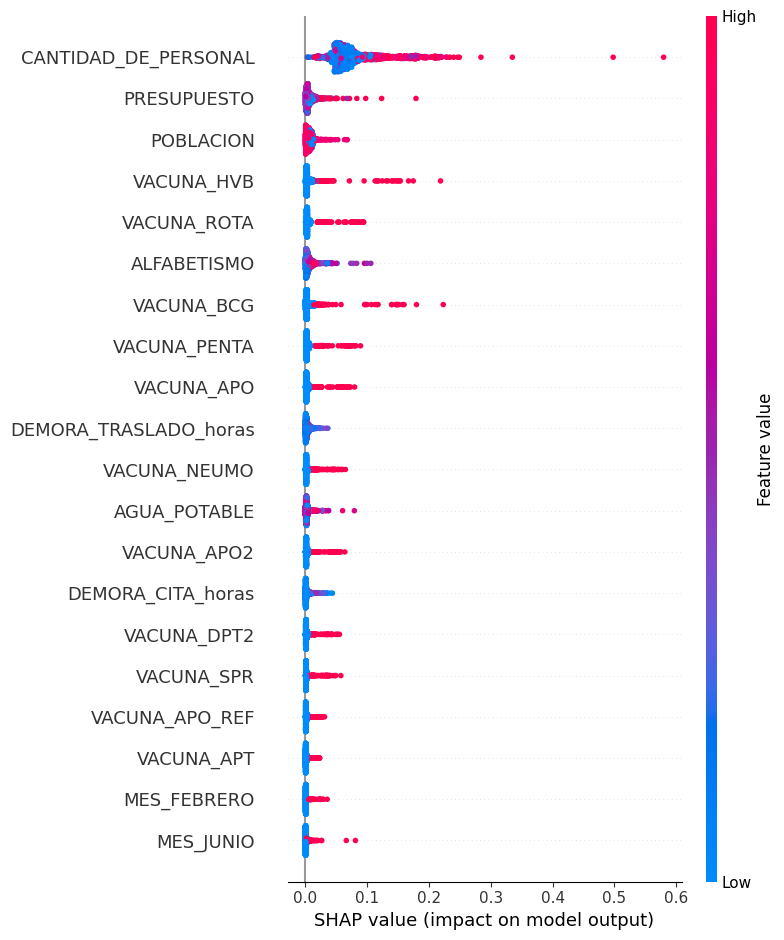

In [68]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(np.abs(shap_values), X_train)

In [69]:
import matplotlib.pyplot as plt

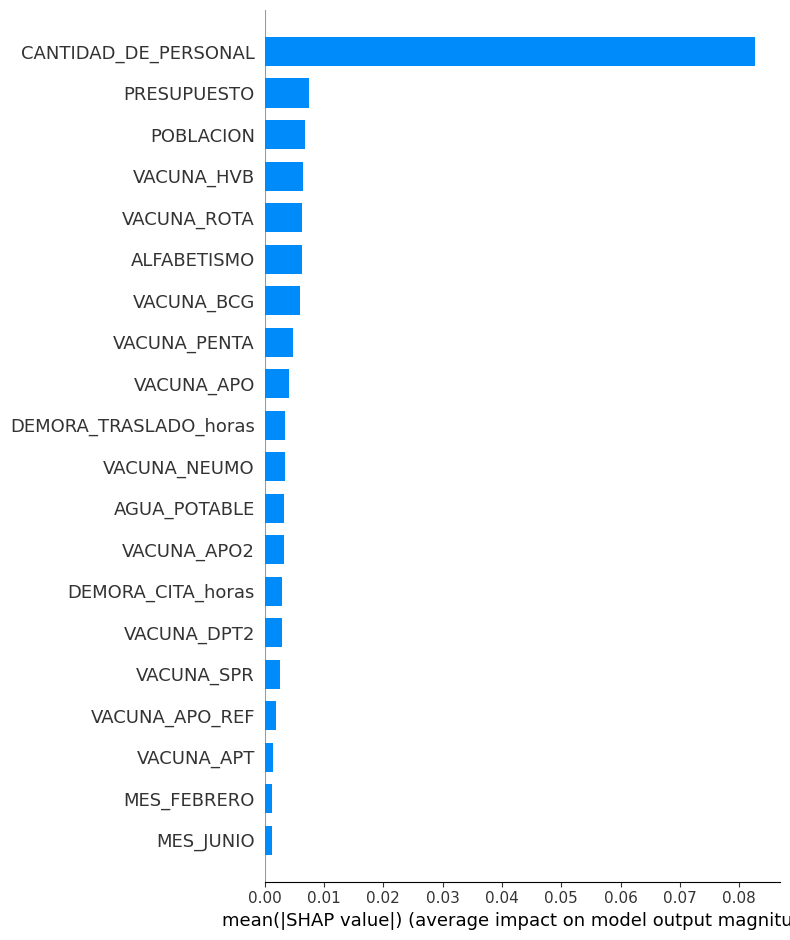

In [70]:
shap.summary_plot(shap_values, X_train,feature_names=X_train.columns, plot_type="bar")
plt.show()

In [71]:
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
shap_df.abs().describe()

,CANTIDAD_DE_PERSONAL,POBLACION,PRESUPUESTO,ALFABETISMO,AGUA_POTABLE,DEMORA_CITA_horas,DEMORA_TRASLADO_horas,ANIO_2019,ANIO_2020,ANIO_2021,...,VACUNA_APT,VACUNA_BCG,VACUNA_DPT2,VACUNA_HVB,VACUNA_INFLUENZA,VACUNA_NEUMO,VACUNA_PENTA,VACUNA_ROTA,VACUNA_SPR,VACUNA_VARI
count,1411.000000,1411.000000,1411.000000,1411.000000,1.411000e+03,1411.000000,1411.000000,1.411000e+03,1.411000e+03,1411.000000,...,1411.000000,1.411000e+03,1411.000000,1411.000000,1.411000e+03,1411.000000,1411.000000,1411.000000,1411.000000,1.411000e+03
mean,0.082724,0.006857,0.007515,0.006288,3.330182e-03,0.002941,0.003481,2.834593e-04,4.080455e-04,0.000706,...,0.001480,5.925132e-03,0.002866,0.006448,4.264857e-04,0.003364,0.004851,0.006291,0.002593,1.186613e-03
std,0.046796,0.006077,0.010093,0.008795,4.835726e-03,0.004435,0.004064,7.397764e-04,5.732088e-04,0.000865,...,0.003015,1.655166e-02,0.005981,0.017273,1.080608e-03,0.006776,0.009887,0.012123,0.005678,3.410100e-03
min,0.003267,0.000023,0.000004,0.000015,9.302137e-07,0.000002,0.000005,4.102640e-07,3.865330e-08,0.000002,...,0.000021,1.613915e-07,0.000036,0.000003,3.378750e-08,0.000029,0.000314,0.000046,0.000207,6.207861e-07
25%,0.053795,0.002893,0.002366,0.001830,1.196117e-03,0.000545,0.000940,5.791468e-05,5.836885e-05,0.000216,...,0.000417,1.275945e-03,0.000833,0.001658,7.581009e-05,0.001155,0.001648,0.002242,0.000754,1.523302e-04
50%,0.067301,0.006181,0.004437,0.003784,2.036033e-03,0.001332,0.002153,7.993947e-05,1.669195e-04,0.000507,...,0.000604,1.871436e-03,0.001237,0.002215,1.689527e-04,0.001485,0.002070,0.002738,0.000982,3.708379e-04
75%,0.096739,0.009413,0.009699,0.007602,3.384683e-03,0.003527,0.004576,1.765134e-04,5.889188e-04,0.000741,...,0.001362,4.314791e-03,0.002597,0.004297,3.700298e-04,0.002927,0.003822,0.004958,0.002307,1.075727e-03
max,0.579474,0.067732,0.178831,0.105818,7.919065e-02,0.043714,0.036403,9.668847e-03,4.146975e-03,0.008372,...,0.023149,2.229677e-01,0.055062,0.218543,1.364956e-02,0.064751,0.089158,0.094387,0.057312,4.119105e-02


In [72]:
shap.plots.force(explainer.expected_value, shap_values[0], X_train.iloc[0, :])

In [73]:
shap.plots.force(explainer.expected_value, shap_values[8], X_train.iloc[0, :])

In [74]:
# Revertir standarizacion
#df.loc[:,cols_sc] = scaler.inverse_transform(df.loc[:,cols_sc].to_numpy())

In [75]:
mse_eval_2 = mean_squared_error(y_test, y_pred)
mape_2 = mean_absolute_percentage_error(y_test, y_pred)
r2_2 = r2_score(y_test, y_pred)
acc_2 = 1 - mean_absolute_percentage_error(y_test, y_pred)
print(f"Error cuadrático medio en el conjunto de evaluación: {mse_eval_2}")
print(f"mape en el conjunto de evaluación: {mape_2}")
print(f"r2 en el conjunto de evaluación: {r2_2}")
print("1-MAPE:", acc_2)

Error cuadrático medio en el conjunto de evaluación: 0.0026056795364163437
mape en el conjunto de evaluación: 0.45120762642202844
r2 en el conjunto de evaluación: 0.7992563607295067
1-MAPE: 0.5487923735779716


In [76]:
def InverseScaler(vector, pos = 0):
    sc_vector = np.zeros((vector.shape[0],4))
    sc_vector[:,pos] = vector
    sc_vector = scaler.inverse_transform(sc_vector)
    vector = sc_vector[:,pos]
    return vector

In [77]:
y_predict_train = model.predict(X_train)
y_predict_train = InverseScaler(y_predict_train)
y_train = InverseScaler(y_train)


In [78]:
dic = {
    'Y_train': y_train,
    'Y_predict_train': y_predict_train,
    'row_mape': np.abs(y_train - y_predict_train)/y_train
}

C:\Users\joaqu\AppData\Local\Temp\ipykernel_10620\1518827332.py:4: RuntimeWarning: divide by zero encountered in divide
  'row_mape': np.abs(y_train - y_predict_train)/y_train


In [79]:
Error_df = pd.DataFrame(dic).sort_values(by='row_mape', ascending=False)

In [80]:
Error_df

,Y_train,Y_predict_train,row_mape
769,0.0,0.398162,inf
433,1.0,13.960462,12.960462
1380,1.0,10.982265,9.982265
344,3.0,10.442255,2.480752
493,1.0,-1.231975,2.231975
...,...,...,...
703,64.0,64.015275,0.000239
364,484.0,483.922152,0.000161
868,270.0,270.036472,0.000135
879,255.0,255.033833,0.000133


In [81]:
Error_df2 = Error_df[Error_df['row_mape'] != np.inf]
Error_df2

,Y_train,Y_predict_train,row_mape
433,1.0,13.960462,12.960462
1380,1.0,10.982265,9.982265
344,3.0,10.442255,2.480752
493,1.0,-1.231975,2.231975
559,5.0,13.557348,1.711470
...,...,...,...
703,64.0,64.015275,0.000239
364,484.0,483.922152,0.000161
868,270.0,270.036472,0.000135
879,255.0,255.033833,0.000133


In [82]:
Error_df2['row_mape'].mean()

0.10073237676969607

In [83]:
importances = model.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

In [84]:
importance_df

,Feature,Importance
0,CANTIDAD_DE_PERSONAL,0.148312
33,VACUNA_HVB,0.085486
31,VACUNA_BCG,0.082253
38,VACUNA_SPR,0.068768
37,VACUNA_ROTA,0.065624
29,VACUNA_APO_REF,0.062236
27,VACUNA_APO,0.054176
3,ALFABETISMO,0.044171
36,VACUNA_PENTA,0.040000
15,MES_FEBRERO,0.036506
